In [1]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import numpy as np

%load_ext tensorboard


In [3]:
def create_train_validate_gen(model_type, rescaling_factor, image_path, batch_size):
    # Create train and validate generators for bacteria data from ImageDataGenerator 

    if 'resnet' in model_type :
        train_datagen = ImageDataGenerator(rescale = rescaling_factor,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,                   
                    validation_split = 0.2,
                    preprocessing_function = preprocess_input)  # Use specific data preprocessing function for resnet
                
    else:
        
        train_datagen = ImageDataGenerator(rescale = rescaling_factor,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,                   
                    validation_split = 0.2,)      
        
    # Train and validate generators
    train_generator = train_datagen.flow_from_directory(
                  image_path,
                  target_size = (224,224),
                  batch_size = batch_size,
                  class_mode = 'categorical',
                  subset = 'training')
    
    validation_generator = train_datagen.flow_from_directory(
                       image_path, 
                       target_size = (224, 224),
                       batch_size = batch_size,
                       class_mode ='categorical',
                       subset ='validation')    # set as validation data)
    
    
    return train_datagen, train_generator, validation_generator
    

In [5]:
def create_model_head(baseModel, dense1, dropout, num_classes):
    # Create model head to put atop pre-trained networks
    
    headModel = baseModel.output
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(dense1, activation="relu")(headModel)
    headModel = Dropout(dropout)(headModel)
    headModel = Dense(num_classes, activation="softmax")(headModel)
    
    return headModel

def train_head_model(init_lr, batch_size, num_epochs, train_generator, validation_generator, callbacks):
    # Compile and train the head model component
    
    print("[INFO] compiling model...")
    opt = Adam(lr = init_lr, decay = init_lr / num_epochs)
    model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=["accuracy"])
    

    print("[INFO] training head...")
    history = model.fit(train_generator,
              steps_per_epoch = train_generator.samples // batch_size,
              validation_data = validation_generator, 
              validation_steps = validation_generator.samples // batch_size,
              epochs = num_epochs,
              callbacks=[tensorboard_callback])
    
    return history

def plot_acc_loss(model_history):
    # Plot training/validation accuracy and loss
    
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, num_epochs), model_history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, num_epochs), model_history.history["val_loss"], label="val_loss")

    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    plt.figure()
    plt.plot(np.arange(0, num_epochs), model_history.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, num_epochs), model_history.history["val_accuracy"], label="val_acc")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower left")

 # VGG16 Model:

In [19]:
from tensorflow.keras.applications import VGG16

# VGG16 Model Parameters 
model_type = 'vgg16'
num_epochs = 30 
batch_size = 32
init_lr = 1e-3
rescaling_factor = 1./255
image_path = './Bacteria/Train'

# Data generators
train_datagen, train_generator, validation_generator = create_train_validate_gen(model_type, rescaling_factor, image_path, batch_size) 

# Create base model
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze kayers of base model
for layer in baseModel.layers:
    layer.trainable = False

# Create head model
headModel = create_model_head(baseModel, 1024, 0.2, 33)

# Place the head FC model on top of the base model 
model = Model(inputs = baseModel.input, outputs = headModel)
   
# Create log directory for train and validate and callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

# Train model head
vgg16_history = train_head_model(init_lr, batch_size, num_epochs, train_generator, validation_generator, tensorboard_callback)    
   

# Save model    
model.save('./models/Vgg16_model') 

Found 514 images belonging to 33 classes.
Found 109 images belonging to 33 classes.
[INFO] compiling model...
[INFO] training head...
Epoch 1/30
16/16 [==============================] - 169s 11s/step - loss: 6.1806 - accuracy: 0.1152 - val_loss: 2.6024 - val_accuracy: 0.4479
Epoch 2/30
16/16 [==============================] - 168s 10s/step - loss: 2.8179 - accuracy: 0.3278 - val_loss: 1.6894 - val_accuracy: 0.4688
Epoch 3/30
16/16 [==============================] - 158s 10s/step - loss: 1.8515 - accuracy: 0.4253 - val_loss: 1.4406 - val_accuracy: 0.5521
Epoch 4/30
16/16 [==============================] - 159s 10s/step - loss: 1.4751 - accuracy: 0.5062 - val_loss: 1.0674 - val_accuracy: 0.6875
Epoch 5/30
16/16 [==============================] - 158s 10s/step - loss: 1.2524 - accuracy: 0.5871 - val_loss: 1.1679 - val_accuracy: 0.6771
Epoch 6/30
16/16 [==============================] - 157s 10s/step - loss: 1.2316 - accuracy: 0.6017 - val_loss: 1.0026 - val_accuracy: 0.7500
Epoch 7/30
16/

AttributeError: 'History' object has no attribute 'save'

In [20]:
model.save('./models/Vgg16_model') 

INFO:tensorflow:Assets written to: ./models/Vgg16_model\assets


# ResNet50 Model:

In [27]:
from tensorflow.keras.applications.resnet50 import ResNet50

# ResNet50 Model Parameters 
model_type = 'resnet50'
num_epochs = 50 
batch_size = 32
init_lr = 1e-3
rescaling_factor = None
image_path = './Bacteria/Train'

# Data generators
train_datagen, train_generator, validation_generator = create_train_validate_gen(model_type, rescaling_factor, image_path, batch_size) 

# Create base model
baseModel = ResNet50(include_top=False, weights = 'imagenet', input_tensor=Input(shape=(224, 224, 3)), pooling = 'avg')

# Freeze kayers of base model
for layer in baseModel.layers:
    layer.trainable = False

# Create head model
headModel = create_model_head(baseModel, 1024, 0.2, 33)

# Place the head FC model on top of the base model 
model = Model(inputs = baseModel.input, outputs = headModel)
   
# Create log directory for train and validate and callback
res_log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = res_log_dir, histogram_freq = 1)

# Train model head
res50_history = train_head_model(init_lr, batch_size, num_epochs, train_generator, validation_generator, tensorboard_callback)    
   

# Save model    
model.save('/models/ResNet50_model') 

Found 514 images belonging to 33 classes.
Found 109 images belonging to 33 classes.
[INFO] compiling model...
[INFO] training head...
Epoch 1/50
16/16 [==============================] - 59s 4s/step - loss: 2.9272 - accuracy: 0.2559 - val_loss: 1.7141 - val_accuracy: 0.5000
Epoch 2/50
16/16 [==============================] - 57s 4s/step - loss: 1.4660 - accuracy: 0.5664 - val_loss: 0.8694 - val_accuracy: 0.7500
Epoch 3/50
16/16 [==============================] - 54s 3s/step - loss: 0.9714 - accuracy: 0.6784 - val_loss: 0.6442 - val_accuracy: 0.8333
Epoch 4/50
16/16 [==============================] - 53s 3s/step - loss: 0.7432 - accuracy: 0.7593 - val_loss: 0.4131 - val_accuracy: 0.9167
Epoch 5/50
16/16 [==============================] - 54s 3s/step - loss: 0.5879 - accuracy: 0.8029 - val_loss: 0.4537 - val_accuracy: 0.8958
Epoch 6/50
16/16 [==============================] - 54s 3s/step - loss: 0.5000 - accuracy: 0.8465 - val_loss: 0.2770 - val_accuracy: 0.9583
Epoch 7/50
16/16 [========

# Inception V3 Model:

In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# ResNet50 Model Parameters 
model_type = 'inceptionv3'
num_epochs = 20 
batch_size = 32
init_lr = 1e-3
rescaling_factor = 1./255
image_path = './Bacteria/Train'

# Data generators
train_datagen, train_generator, validation_generator = create_train_validate_gen(model_type, rescaling_factor, image_path, batch_size) 

# Create base model
baseModel = InceptionV3(include_top=False, weights = 'imagenet', input_tensor=Input(shape=(224, 224, 3)))

# Freeze kayers of base model
for layer in baseModel.layers:
    layer.trainable = False

# Create head model
headModel = create_model_head(baseModel, 1024, 0.2, 33)

# Place the head FC model on top of the base model 
model = Model(inputs = baseModel.input, outputs = headModel)
   
# Create log directory for train and validate and callback
inc_log_dir = "logs/InceptionV3/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = inc_log_dir, histogram_freq = 1)

# Train model head
incV3_history = train_head_model(init_lr, batch_size, num_epochs, train_generator, validation_generator, tensorboard_callback)    
   

# Save model    
model.save('./models/InceptionV3_model') 

Found 514 images belonging to 33 classes.
Found 109 images belonging to 33 classes.
[INFO] compiling model...
[INFO] training head...
Epoch 1/30
 1/16 [>.............................] - ETA: 0s - loss: 3.8310 - accuracy: 0.0312WARNING:tensorflow:From C:\Users\Ed\.conda\envs\tf\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
16/16 [==============================] - 53s 3s/step - loss: 25.0468 - accuracy: 0.1426 - val_loss: 8.4319 - val_accuracy: 0.4062
Epoch 2/30
16/16 [==============================] - 52s 3s/step - loss: 6.2796 - accuracy: 0.3797 - val_loss: 2.6152 - val_accuracy: 0.5208
Epoch 3/30
16/16 [==============================] - 50s 3s/step - loss: 2.6022 - accuracy: 0.4793 - val_loss: 1.6888 - val_accuracy: 0.5625
Epoch 4/30
16/16 [==============================] - 50s 3s/step - loss: 1.3782 

AttributeError: 'History' object has no attribute 'save'

In [8]:
model.save('./models/InceptionV3_model') 
# Tensor board

#%tensorboard --logdir=logs/InceptionV3/fit/ --host localhost --port 8088

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/InceptionV3_model\assets


In [ ]:
model = tensorflow.keras.models.load_model('./models/InceptionV3_model')

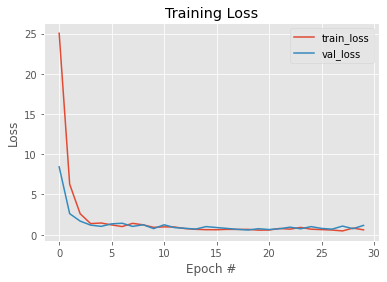

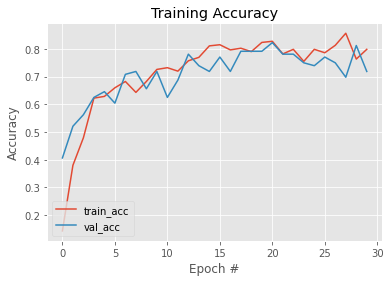

In [18]:
plot_acc_loss(incV3_history)